<a href="https://colab.research.google.com/github/Nedu21/Keras-deep-learning-projects/blob/main/Time_series_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

In [ ]:
# Create a synthetic stock price data
np.random.seed(42)
data_length = 2000
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a Dataframe and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=["Close"])
data.to_csv('stock_prices.csv', index=False)
print('Synthetic stock_prices.csv created and loaded')

Synthetic stock_prices.csv created and loaded


In [ ]:
# Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
  X, Y = [], []

  for i in range(len(data)-time_step-1):
    a = data[i:(i + time_step), 0]
    X.append(a)
    Y.append(data[i + time_step, 0]) # Corrected line
  return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
print(X.shape)
X = X.reshape(X.shape[0], X.shape[1], 1)

print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

(1899, 100)
Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In [ ]:
# Implement Multi-Head Self-Attention
class MultiHeadSelfAttention(Layer):

  def __init__(self, embed_dim, num_heads=8):
    super(MultiHeadSelfAttention, self).__init__()
    self.embed_dim = embed_dim
    self.num_heads = num_heads
    self.projection_dim = embed_dim // num_heads
    self.query_dense = Dense(embed_dim)
    self.key_dense = Dense(embed_dim)
    self.value_dense = Dense(embed_dim)
    self.combine_heads = Dense(embed_dim)

  def attention(self, query, key, value):
    score = tf.matmul(query, key, transpose_b=True)
    dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_score = score / tf.math.sqrt(dim_key)
    weights = tf.nn.softmax(scaled_score,axis=-1)
    output = tf.matmul(weights, value)
    return output, weights

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]
    query = self.query_dense(inputs)
    key = self.key_dense(inputs)
    value = self.value_dense(inputs)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)
    attention, _ = self.attention(query, key, value)
    attention = tf.transpose(attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
    output = self.combine_heads(concat_attention)
    return output

In [ ]:
# Implement transformer block
class TransformerBlock(Layer):

  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadSelfAttention(embed_dim, num_heads)
    self.ffn = tf.keras.Sequential([
        Dense(ff_dim, activation='relu'),
        Dense(embed_dim),
    ])
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.att(inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return(out1 + ffn_output)

In [ ]:
# Implement the transformer encoder
class TransformerEncoder(Layer):

  def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerEncoder, self).__init__()
    self.num_layers = num_layers
    self.embed_dim = embed_dim
    self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.dropout = Dropout(rate)

  def call(self, inputs, training=False):
    x = inputs
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training=training)
    return x

In [ ]:
# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform(shape=(1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)
print(outputs.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_6', how

(1, 100, 128)


In [ ]:
# Build and compile the transformer model
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the transformer encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project inputs to embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_10', ho

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_2           │ (None, 100, 128)       │       792,064 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,121 (3.07 MB)

 Trainable params: 805,121 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 641ms/step - loss: 27.9219
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 618ms/step - loss: 0.2924
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 632ms/step - loss: 0.2393
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 613ms/step - loss: 0.2090
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 636ms/step - loss: 0.1956
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 607ms/step - loss: 0.2481
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 611ms/step - loss: 0.2305
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - loss: 0.1944
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 614ms/step - loss: 0.1694
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 597ms/step - loss: 0.1378
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 611ms/step - loss: 0.1644
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step - loss: 0.1139
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 613ms/step - loss: 0.1197
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - loss: 0.1267
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s

60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step


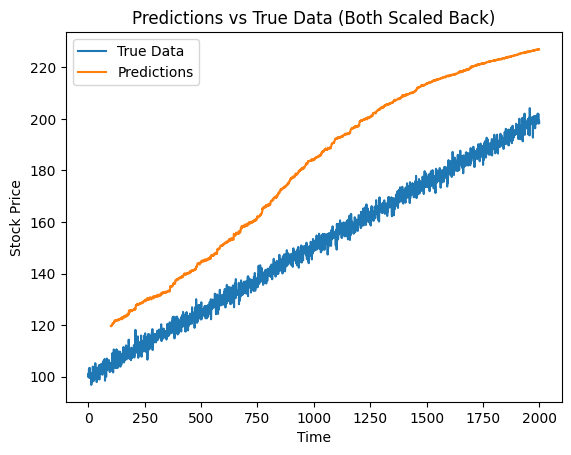

In [14]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Prepare values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt

plt.plot(true_values, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show()

In [16]:
# Add dropout to the Transformer model
from tensorflow.keras.layers import Dropout

# Add a dropout layer after the Flatten layer
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 51s 655ms/step - loss: 3.9216
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 619ms/step - loss: 0.6112
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 624ms/step - loss: 0.4858
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 655ms/step - loss: 0.3762
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 628ms/step - loss: 0.2566
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 628ms/step - loss: 0.1987
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 631ms/step - loss: 0.1424
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 631ms/step - loss: 0.1258
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 632ms/step - loss: 0.0864
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 635ms/step - loss: 0.0799
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 654ms/step - loss: 0.0526
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 637ms/step - loss: 0.0464
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 46s 772ms/step - loss: 0.0411
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 723ms/step - loss: 0.0341
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 

In [17]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 37s 312ms/step - loss: 0.0222
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 316ms/step - loss: 0.0385
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - loss: 0.0402
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - loss: 0.0618
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - loss: 0.0417
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 317ms/step - loss: 0.0320
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - loss: 0.0263
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 321ms/step - loss: 0.0207
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 320ms/step - loss: 0.0208
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - loss: 0.0147
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - loss: 0.0175
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - loss: 0.0188
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 39s 317ms/step - loss: 0.0121
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - loss: 0.0098
Epoch 15/20
119

In [18]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 50s 626ms/step - loss: 0.3028
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 626ms/step - loss: 0.2974
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 635ms/step - loss: 0.3010
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 654ms/step - loss: 0.3019
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 658ms/step - loss: 0.2937
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 630ms/step - loss: 0.2936
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 629ms/step - loss: 0.2908
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 626ms/step - loss: 0.3026
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 626ms/step - loss: 0.2889
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 626ms/step - loss: 0.2893
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 622ms/step - loss: 0.2890
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 650ms/step - loss: 0.3046
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step - loss: 0.3028
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 611ms/step - loss: 0.3026
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 